# Introduction to LangGraph
I will be using this notebook to take notes on the [Introduction to LangGraph](https://www.youtube.com/watch?v=J5d1l6xgQBc) video. Up until now, I have been using LangChain to perform simple tasks like interacting with an LLM. However, as tasks get more complicated, I'm going to need to use a more complex tool to apply thinking and reasoning within my models. LangChain used to offer ways to implement ReAct Agents that use tools in order to execute more complex tasks. Nonetheless, these agents have been deprecated and superceeded by LangGraph agents which are easier to implement and more powerful than oldschool ReAct agents. I think this is a good point to dedicate some time learning the basics of LangGraph so I can migrate to it when agents and workflows come into play.

## .env files
A common technique that I've seen people use is .env files. These types of files usually contain information that should not be visible by the user, like API keys, passwords or even hostnames. By using python-dotenv, you can automatically import those secrets into your project.

In [1]:
from dotenv import load_dotenv
load_dotenv()

False

I'm not a huge fan of this technique since I don't like all my secrets to be exposed onto a simple file that can be easily accessed or accidentally pushed to GitHub. Sure, I could implement a .gitignore file but I would much prefer a technique that completely allows me to store precious information like API keys somewhere where it's hard to spot them. 

## Nodes & Edges
I like to think that LangGraph is the natural evolution of LangChain. Let's think back to something all of us are familiar with; Data Structures. It all started with a simple one dimensional linked list. Don't get me wrong, linked lists get the job done, but there are plenty more ways to store, manage and access information. This is exactly why we came up with the idea of Trees. Due to the structure of Trees, each time we perform an action to move on to the next node, we can reduce the amount of remaining nodes that we should visit up to 50% (Binary Trees)! And then, you guessed it, trees evolved into graphs which are essentially more diverse trees. 
Can you see the parallel between Data Structures and Lang libraries? LangChain essentially resembles a linked list that sequentially executes commands and uses tools. LangGraph on the other hand consists of nodes and edges, much like a graph.

In [2]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

def add_one(input : list[HumanMessage]):
    """
    Appends an 'a' to the input's first message
    """
    input[0].content = input[0].content + "a"
    return input

# Initialize a graph where each node contains messages
graph = MessageGraph()

# Initialize 3 nodes. Each node contains a key(name) and a function
graph.add_node("branch_a", add_one)
graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

# Connect the nodes with edges
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

# Initialize the final node
graph.add_node("final_node", add_one)
graph.add_edge("final_node", END)

# Make nodes b and c connect to the final node
graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

# Initialize the entry point. This is where the workflow starts executing
graph.set_entry_point("branch_a")

# Compile the graph and create a runnable that can be later invoked
runnable = graph.compile()

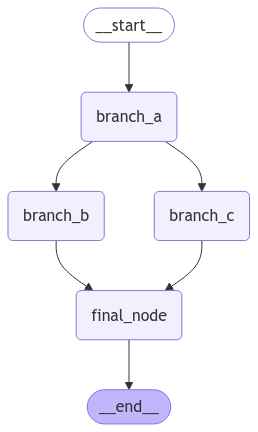

In [3]:
# This visualizes the compiled graph 
from IPython.display import Image, display
display(Image(runnable.get_graph().draw_mermaid_png()))

In [4]:
runnable.invoke("a")

[HumanMessage(content='aaaaa', additional_kwargs={}, response_metadata={}, id='14434ff4-dbfd-4939-a16b-65511de87d9e')]

## Conditional Edges
Ok so we got a basic grasp of how nodes and edges function. Essentially, each node runs the function stored in it and then connects with a new node. But what if we want a node to behave differently depending on its input? 

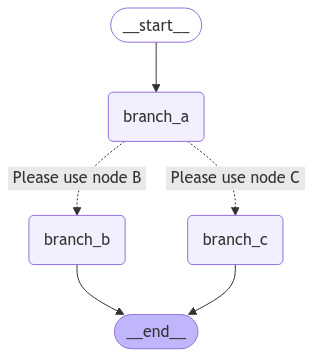

In [5]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

def entry(input : list[HumanMessage]):
    """
    Returns the given input
    """
    return input

def work_with_b(input : list[HumanMessage]):
    """
    Executes work on branch B
    """
    print("Using branch B")
    return input

def work_with_c(input : list[HumanMessage]):
    """
    Executes work on branch C
    """
    print("Using branch C")
    return input

def router(input : list[HumanMessage]):
    """
    Decides which node should be used
    """
    if "use_b" in input[0].content:
        return "Please use node B"
    else:
        return "Please use node C"
    
# Init graph
graph = MessageGraph()
graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)
graph.set_entry_point("branch_a")

# Use the router to connect node A to nodes B and C. The decision is based on the router's return value
graph.add_conditional_edges(
    "branch_a",
    router,
    {"Please use node B" : "branch_b", "Please use node C" : "branch_c",}
)

# Init end of graph
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

# Compile and show graph. Condition edges are marked with dotted lines
runnable = graph.compile()
display(Image(runnable.get_graph().draw_mermaid_png()))

In [6]:
# Let's test the graph
runnable.invoke("Hello")

Using branch C


[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='7c0f713d-f567-4659-929d-5df4c89e3bfc')]

In [7]:
runnable.invoke("Greetings. It's time you use_b")

Using branch B


[HumanMessage(content="Greetings. It's time you use_b", additional_kwargs={}, response_metadata={}, id='b483ac8f-67c8-4009-af77-70bb2bc66890')]

In [8]:
runnable.invoke("Yo. It's time you use_c")

Using branch C


[HumanMessage(content="Yo. It's time you use_c", additional_kwargs={}, response_metadata={}, id='229bec6d-a72d-4a7f-9e3e-72753a4e3206')]

## Cycles
One of the most powerful capabilities of LangGraph is the implementations of cycles. Essentially, by creating a cycle between two or more nodes inside our graph we can create a workflow that repeats the same steps until a condition is met.

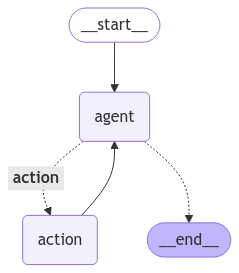

In [ ]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

def entry(input : list[HumanMessage]):
    """
    Entry function that does nothing
    """
    return input

def action(input : list[HumanMessage]):
    """ 
    Take an action according to the length of the input list
    """
    print("Action taken: ", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input

def should_continue(input : list[HumanMessage]):
    """
    Decides which node should be used according to the input. Works like the router in the previous example.
    """
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "__action__"

# Init graph
graph = MessageGraph()
graph.add_node("agent", entry)
graph.set_entry_point("agent")
graph.add_node("action", action)

# Decide what happens according to the output of should_continue()
graph.add_conditional_edges(
    "agent",
    should_continue,
    {"__action__" : "action", "__end__" : END}
)
# Make sure you add an edge from action to agent to ensure a cycle
graph.add_edge("action", "agent")

# Compile and show graph. Condition edges are marked with dotted lines
runnable = graph.compile()
display(Image(runnable.get_graph().draw_mermaid_png()))

In [10]:
runnable.invoke("Hello!")

Action taken:  ['Hello!']
Action taken:  ['Hello!', 'continue']
Action taken:  ['Hello!', 'continue', 'continue']
Action taken:  ['Hello!', 'continue', 'continue', 'continue']
Action taken:  ['Hello!', 'continue', 'continue', 'continue', 'continue']
Action taken:  ['Hello!', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='e97c95a0-cdd8-4c17-8e21-7920dbfe40c7'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='7523aac8-16ee-48e2-a4f3-1b00e608ac6f'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='a07a48d4-3402-486e-8051-188b11997af7'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='80796c06-5ff4-4c6e-8858-dc21ce723073'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='ce58124f-597d-42b9-8944-d21b5bc00369'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='3ff33222-3c99-4882-92f0-c90932553542'),
 HumanMessage(content='end', additional_kwargs={}, response_metadata={}, id='e5adb1f4-d450-4717-a7cc-9f18643c6769')]

## Real Agent
Ok. So we know how LangGraph graphs work. Let's incorporate a real agent that actually does something. The first step is to build our own state.

In [11]:
from langchain_core.messages import BaseMessage
import operator
from typing import TypedDict, Annotated, Sequence

# We define a state to be a typed dictionary with predefined key types
class AgentState(TypedDict):
    # messages is a list of BaseMessages.
    # By adding operator.add, LangGraph will combine messages using addition when updating states
    # Essentially, each new message will be appended to the list
    messages : Annotated[Sequence[BaseMessage], operator.add]
    # Also keep track of the number of API calls
    api_call_count : int = 0

Next, let us build a custom tool that will be used by the LLM.

In [31]:
from langchain_core.tools import tool
import random

# Let's build a custom weather API that randomly only works one third of the time.
@tool
def weather_api(city : str) -> str:
    """
    Check the weather in a specified city. The API is available randomly, approximately every 3rd call.
    """
    if random.randint(1,3) == 1:
        return "Sunny, 22 degrees Celsius"
    else:
        return "Service temporarily unavailable"
    
print(weather_api("Athens"))
print(weather_api("Thessaloniki"))
print(weather_api("Patra"))

Service temporarily unavailable
Service temporarily unavailable
Sunny, 22 degrees Celsius


Now that we have a tool, we need to bind it to our LLM so it can use it.

In [13]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# Model init
import os
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY, temperature=0)

# Bind it with a list of tools
tools = []
tools.append(weather_api)
llm_with_tools = model.bind_tools(tools)

# Invoke the model
chat_history = []
chat_history.append(HumanMessage("How will the weather be in Athens, Greece today? I would like to eat outside if possible"))
llm_output = llm_with_tools.invoke(chat_history)
chat_history.append(llm_output)
print(chat_history)

[HumanMessage(content='How will the weather be in Athens, Greece today? I would like to eat outside if possible', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pygMG4ZjCB98ujPjQqIp8urW', 'function': {'arguments': '{"city":"Athens, Greece"}', 'name': 'weather_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 77, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-13d293e3-6c86-4789-bb9c-1bf62982fa4d-0', tool_calls=[{'name': 'weather_api', 'args': {'city': 'Athens, Greece'}, 'id': 'call_pygMG4ZjCB98ujPjQqIp8urW', 'type': 'tool_call'}], usage_m

As you can see from the AI message, the model tried to call the weather_api() tool using "Athens, Greece" as its argument. Let's call the tool using tool calling. 

In [14]:
from langchain_core.messages import ToolMessage

# The first thing we need to do is to use a tool map
tool_map = {"weather_api" : weather_api}

# Next, we cycle through all the tool calls of the llm and get the output of the function
for tool_call in llm_output.tool_calls:
    tool = tool_map[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    chat_history.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

# Now that the tool's output has been added to the chat history, the llm can be invoked to produce the final message
llm_with_tools.invoke(chat_history)

AIMessage(content='The weather in Athens, Greece today is sunny with a temperature of 22 degrees Celsius. It sounds like a great day to eat outside! Enjoy your meal!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 108, 'total_tokens': 142, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_709714d124', 'finish_reason': 'stop', 'logprobs': None}, id='run-2f63e3c9-25ca-4cf6-b953-37fd27d93ad6-0', usage_metadata={'input_tokens': 108, 'output_tokens': 34, 'total_tokens': 142, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Great! Now let's implement the above logic into a LangGraph workflow

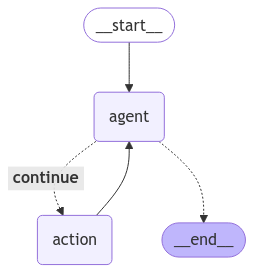

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that. These tools sometimes fail and you are very resilient and try them again.', additional_kwargs={}, response_metadata={}), HumanMessage(content='How is the weather in Athens, Greece today?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_e2eajYRcXY4JUX6wl1fgu1UH', 'function': {'arguments': '{"city":"Athens, Greece"}', 'name': 'weather_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 96, 'total_tokens': 114, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7fcd609668', 'finish_reason': 'tool_calls', 'logprobs': Non

In [ ]:
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

from IPython.display import Image, display
import operator
import os
import random
from typing import TypedDict, Annotated, Sequence

# We define a state to be a typed dictionary with predefined key types
class AgentState(TypedDict):
    # messages is a list of BaseMessages.
    # By adding operator.add, LangGraph will combine messages using addition when updating states
    # Essentially, each new message will be appended to the list
    messages : Annotated[Sequence[BaseMessage], operator.add]
    # Also keep track of the number of API calls
    api_call_count : int = 0


# Let's build a custom weather API that randomly only works one third of the time.
@tool
def weather_api(city : str) -> str:
    """
    Check the weather in a specified city. The API is available randomly, approximately every 3rd call.
    """
    if random.randint(1,3) == 1:
        return "Sunny, 22 degrees Celsius"
    else:
        return "Service temporarily unavailable"

tool_map = {"weather_api" : weather_api}    

# Initialize model
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(model="gpt-4o-mini", openai_api_key=OPENAI_API_KEY, temperature=0)

# Bind it with a list of tools
tools = []
tools.append(weather_api)
llm_with_tools = model.bind_tools(tools)


# Router function
def should_continue(state : AgentState) -> str:
    """
    Returns what the next step is
    """
    print(f"STATE: {state}")

    # If the last message contains a tool call, the llm is not done
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "__end__"
    else:
        return "__continue__"

def call_model(state : AgentState) -> AgentState:
    """
    Invoke the model so it tries to do something, like calling a tool
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages" : [response], "api_call_count" : state["api_call_count"]}

def call_tool(state : AgentState) -> AgentState:
    """
    Calls a tool and appends its output to the state
    """
    # Get the tool from the last message
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_map[tool_call["name"].lower()]

    # Call the tool and print the output. Since the tool was called, also raise the API count of the state
    tool_output = tool.invoke(tool_call["args"])
    state["api_call_count"] += 1
    print(f"Tool output: {tool_output}")
    print(f"API call count after this tool call: {state["api_call_count"]}")

    # Append the tool message to the state (this is easily done by operator.add)
    # Don't forget that these functions should return AgentStates!
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages" : [tool_message], "api_call_count" : state["api_call_count"]}

# Initialize a workflow containing states. Each state will have the form of an AgentState
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)
workflow.set_entry_point("agent")

# Connect the nodes and create a loop between agent and action
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"__continue__" : "action", "__end__" : END}
)
workflow.add_edge("action", "agent")

# Compile and show the app
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

# Create a starting prompt
chat_history = []
chat_history.append(SystemMessage(content="You are responsible for answering user questions. You use tools for that. These tools sometimes fail and you are very resilient and try them again."))
chat_history.append(HumanMessage(content="How is the weather in Athens, Greece today?"))

# Invoke the app and print the output
result = app.invoke({"messages" : chat_history, "api_call_count" : 0})
print()
print(f"LLM OUTPUT: {result["messages"][-1].content}")
print(f"TOTAL API CALLS NEEDED TO GET OUTPUT: {result["api_call_count"]}")